In [1]:
#imports
import numpy as np
import torch
from matplotlib import pyplot as plt
from mode_torch import MoDeLoss
from utils import make_plot, Model, DataSet
np.random.seed(42)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# Generating Toy Data
Generate signal mass from a uniform + gaussian distribution.

Generate background mass from a linear distribution $ ax + b $ using inversion transform sampling.

Generate random gaussian variables uncorrelated with mass but different for signal and background.

In [2]:
# Random Variable with linear Distribution 
def get_lin_mass(a=.5,b=.5,n=int(5e5/2),umin=0,umax=1):
    u = np.random.uniform(umin,umax,n)
    return - b/(a) + np.sqrt((b-a)**2 + 2*a*u)/(a)

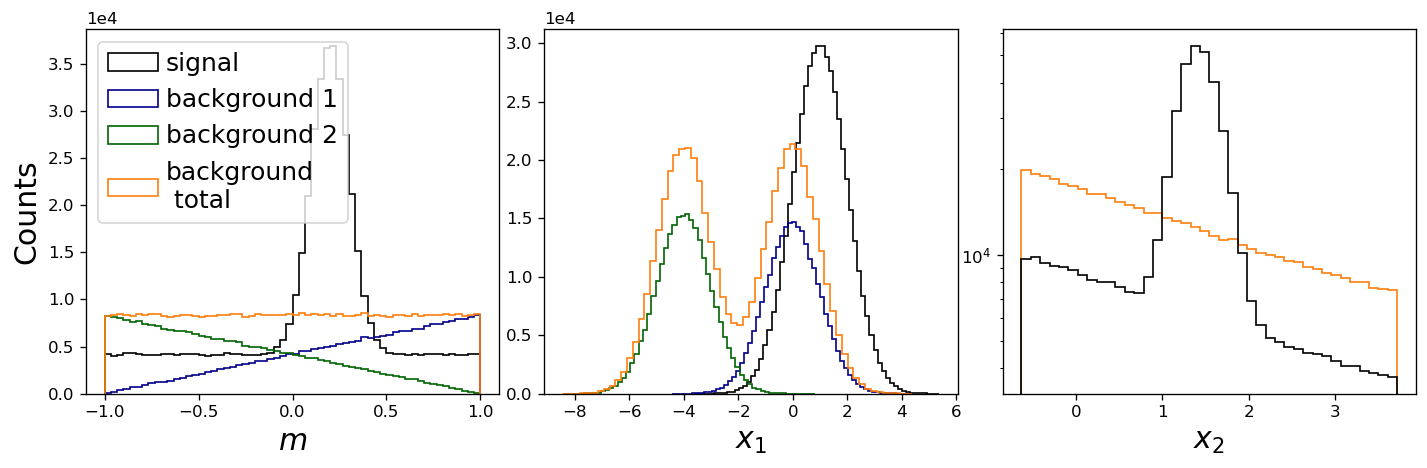

In [3]:
# data
np.random.seed(42)
n_s = int(5e5)
n_b = int(5e5/2)
n_s_gauss_frac = 0.5

m_s = np.concatenate([np.random.uniform(-1,1,n_s-int(n_s_gauss_frac*n_s)), 
                    np.random.normal(0.2,0.1,size=int(n_s_gauss_frac*n_s))])
m_b1 = get_lin_mass(.5,.5,n_b)
m_b2=  get_lin_mass(-.5,.5,n_b)
m_b = np.concatenate([m_b1,m_b2])
m_t1 = get_lin_mass(.5,.5,n_b)
m_t2=  get_lin_mass(-.5,.5,n_b)
m_t  = np.concatenate([m_t1,m_t2])

x1_b1 = np.random.normal(0,1,n_b)
x1_b2 = np.random.normal(-4,1,n_b)
x1_b  = np.concatenate([x1_b1,x1_b2])
x1_s  = np.random.normal(1,1,n_s)
x1_t  = np.concatenate([np.random.normal(0,1,n_b),np.random.normal(-4,1,n_b)])

x2_s = np.exp(m_s)+m_s #np.exp(-(m_s-.2)**2/.01)
x2_b = np.exp(m_b)+m_b #np.exp(-(m_b-.2)**2/.01)
x2_t = np.exp(m_t)+m_t #np.exp(-(m_t-.2)**2/.01)



fig ,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(12,4),dpi=120,sharey=False)

_,bins,_ = ax1.hist(m_s,bins=60,density=False,alpha=1,label='signal',histtype="step",color='black')
ax1.hist(m_b1,bins=bins,density=False,label='background 1',histtype="step",color='darkblue',alpha=1)
ax1.hist(m_b2,bins=bins,density=False,label='background 2',histtype="step",color='darkgreen',alpha=1)
ax1.hist(m_b,bins=bins,density=False,alpha=1,label='background\n total',histtype="step",color='C1')
ax1.legend(loc="upper left",fontsize=15,handletextpad=0.3)
ax1.set_xlabel(r"$m$",fontsize=18)
ax1.set_ylabel("Counts",fontsize=18)
#ax1.set_ylim([0,3.6e4])
ax1.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

ax2.hist(x1_s,bins=60,density=False,alpha=1,label='signal',color='black',histtype='step')
ax2.hist(x1_b1,bins=60,density=False,label='background 1',color='darkblue',histtype="step",alpha=1)
ax2.hist(x1_b2,bins=60,density=False,label='background 2',color='darkgreen',histtype="step",alpha=1)
ax2.hist(x1_b,bins=60,density=False,alpha=1, label='background total',histtype="step",color="C1")
ax2.set_xlabel(r"$x_1$",fontsize=18)
ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

_,bins,_ = ax3.hist(x2_b,bins=40,density=False,alpha=1, label='background',histtype="step",color="C1")
ax3.hist(x2_s,bins=bins,density=False,alpha=1,label='signal',histtype="step",color='black')
ax3.set_xlabel(r"$x_2$",fontsize=18)
ax3.set_yscale("log")
fig.tight_layout(w_pad=0.2)
#fig.savefig("./plots/toy/data.pdf")
##############################################finalize 
x = np.concatenate([np.stack([m_s,x1_s,x2_s],axis=1),
                   np.stack([m_b,x1_b,x2_b],axis=1)])
y = np.concatenate([np.zeros(m_s.size),np.ones(m_b.size)])

x_test = np.stack([m_t,x1_t,x2_t],axis=1) 
y_test = np.ones(x_test.shape[0])
# Shuffling the data
size = y.size
mask = np.arange(size)
np.random.shuffle(mask)

# Train Validation Split
x_train = x[mask][:int(size*0.8)]
y_train = y[mask][:int(size*0.8)]

x_val = x[mask][int(size*0.8):]
y_val = y[mask][int(size*0.8):]


traindataset = DataSet(x_train.astype('float32')[:,1:],y_train.astype('int32'),x_train[::,0].astype('float32'))
valdataset = DataSet(x_val.astype('float32')[:,1:],y_val.astype('int32'),x_val[::,0].astype('float32'))
testTensor= torch.from_numpy(x_test[:,1:]).float()
traindataset2 = DataSet(x_train.astype('float32')[:,1:-1],y_train.astype('int32'),x_train[::,0].astype('float32'))
valdataset2 = DataSet(x_val.astype('float32')[:,1:-1],y_val.astype('int32'),x_val[::,0].astype('float32'))
testTensor2= torch.from_numpy(x_test[:,1:-1]).float()

In [4]:
params = {'epochs'       : 50,
          'interval'     : 10, # every "interval" print validation results
          'batch_size'   : 2**14,
          'shuffle'      : True,
          'num_workers'  : 6, # to load data in preparation of next iteration uses more memory but saves time.
          'drop_last'    : False,
          'device'       : device,
          'pass_x_biased': True,
         }
lr = 1e-2

Entering Training...
Epoch:0001/0050  (3.6  s)
 Train: loss:0.3590, acc:46.7% || Val: loss: 0.3090, acc:43.8%, R50: 1.0808, 1/JSD: 0.6549
Epoch:0010/0050  (24.8 s)
 Train: loss:0.2320, acc:67.0% || Val: loss: 0.2151, acc:67.5%, R50: 14.5359, 1/JSD: 0.7732
Epoch:0020/0050  (48.0 s)
 Train: loss:0.2385, acc:66.8% || Val: loss: 0.2137, acc:67.3%, R50: 14.2269, 1/JSD: 0.9254
Epoch:0030/0050  (71.3 s)
 Train: loss:0.2359, acc:67.1% || Val: loss: 0.2118, acc:67.2%, R50: 14.0346, 1/JSD: 1.0820
Epoch:0040/0050  (94.4 s)
 Train: loss:0.2377, acc:67.2% || Val: loss: 0.2115, acc:67.1%, R50: 13.8899, 1/JSD: 1.2694
Epoch:0050/0050  (117.0s)
 Train: loss:0.2263, acc:71.7% || Val: loss: 0.1912, acc:72.0%, R50: 13.9268, 1/JSD: 6.2270


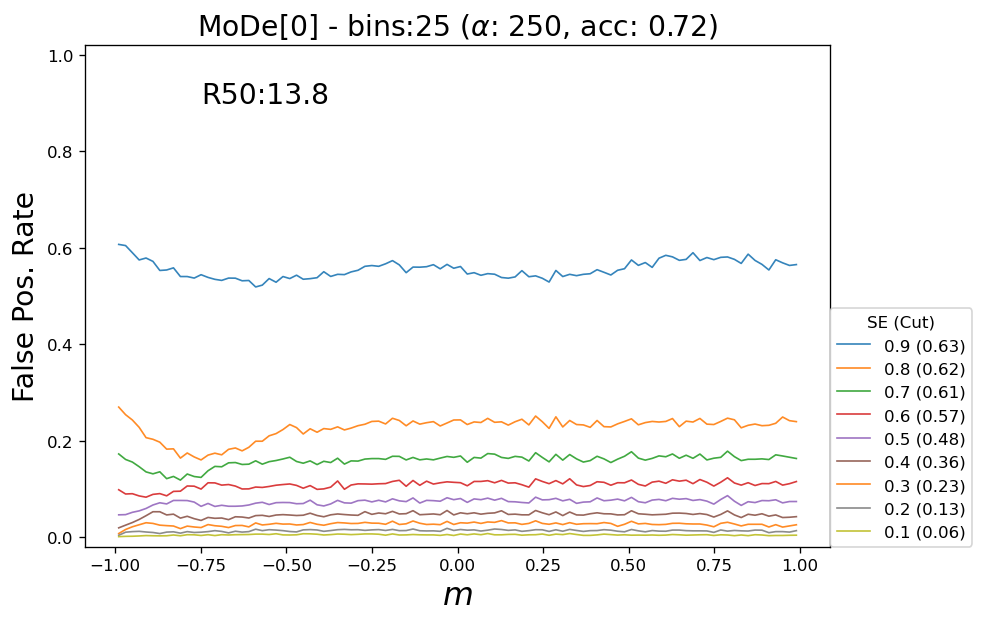

Entering Training...
Epoch:0001/0050  (3.5  s)
 Train: loss:0.2348, acc:78.1% || Val: loss: 0.1811, acc:77.8%, R50: 9.4085, 1/JSD: 0.0866
Epoch:0010/0050  (24.8 s)
 Train: loss:0.1970, acc:77.4% || Val: loss: 0.1623, acc:77.9%, R50: 13.0808, 1/JSD: 0.2444
Epoch:0020/0050  (48.1 s)
 Train: loss:0.2268, acc:78.4% || Val: loss: 0.1556, acc:78.6%, R50: 13.2021, 1/JSD: 0.2589
Epoch:0030/0050  (71.1 s)
 Train: loss:0.2199, acc:77.3% || Val: loss: 0.1606, acc:77.8%, R50: 13.0312, 1/JSD: 0.2441
Epoch:0040/0050  (94.6 s)
 Train: loss:0.2223, acc:77.4% || Val: loss: 0.1618, acc:78.0%, R50: 13.1585, 1/JSD: 0.2566
Epoch:0050/0050  (117.1s)
 Train: loss:0.2387, acc:78.1% || Val: loss: 0.1573, acc:78.0%, R50: 13.2512, 1/JSD: 0.2679


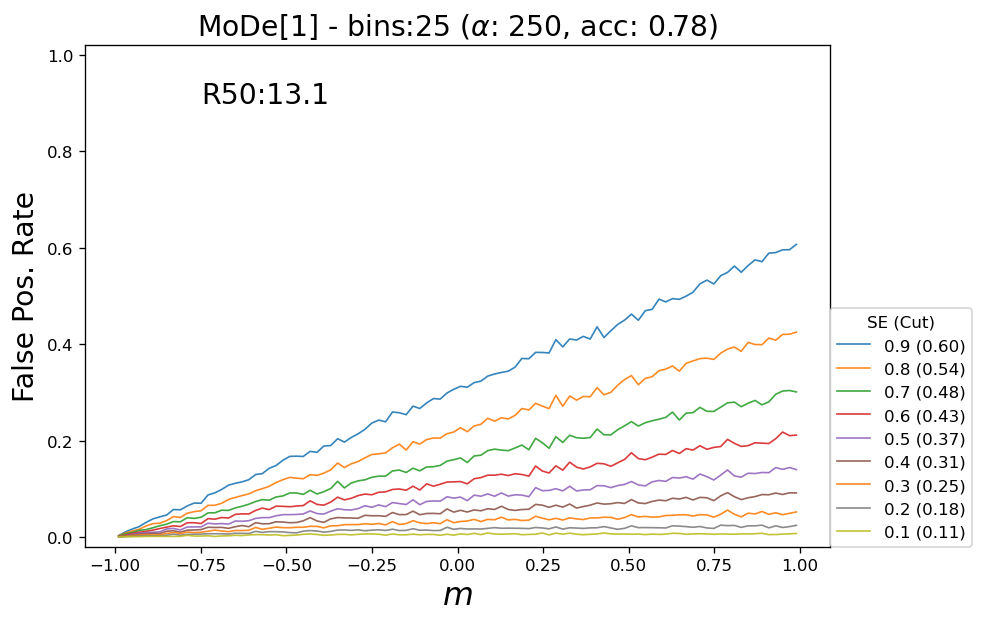

Entering Training...
Epoch:0001/0050  (3.5  s)
 Train: loss:0.2238, acc:79.2% || Val: loss: 0.1502, acc:77.8%, R50: 11.0156, 1/JSD: 0.1224
Epoch:0010/0050  (24.9 s)
 Train: loss:0.1970, acc:78.8% || Val: loss: 0.1502, acc:79.0%, R50: 15.5638, 1/JSD: 0.4127
Epoch:0020/0050  (48.8 s)
 Train: loss:0.2131, acc:78.6% || Val: loss: 0.1509, acc:79.0%, R50: 15.6666, 1/JSD: 0.3568
Epoch:0030/0050  (72.6 s)
 Train: loss:0.2047, acc:78.4% || Val: loss: 0.1560, acc:78.9%, R50: 15.9345, 1/JSD: 0.3240
Epoch:0040/0050  (95.8 s)
 Train: loss:0.2186, acc:78.1% || Val: loss: 0.1566, acc:78.3%, R50: 15.7432, 1/JSD: 0.2963
Epoch:0050/0050  (118.2s)
 Train: loss:0.2182, acc:78.8% || Val: loss: 0.1511, acc:78.9%, R50: 16.0010, 1/JSD: 0.3162


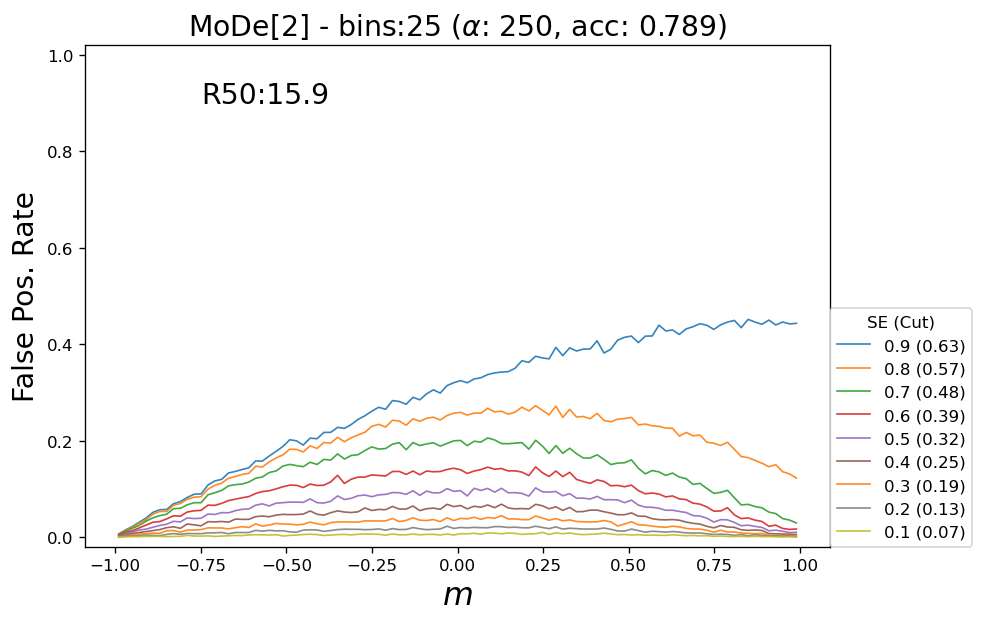

In [5]:
# MoDe 0,1,2.
bins = 25   # MoDe mass bins
alpha = 250 # Relative strength of MoDe loss compared to classification loss
for order in [0,1,2]: # MoDe[order] highest Legendre mode to use
    torch.manual_seed(777)
    model = Model(input_size=traindataset.samples.shape[1]).to(device)
    # Instantiate MoDe Loss 
    MoDe = MoDeLoss(bins=bins,order=order,dynamicbins=True,background_label=1)
                                   #max_slope=slope,eps=1e-5, monotonic=True)
    loss = lambda pred,target,x_biased,weights: alpha * MoDe(pred,target,x_biased,) + torch.mean(weights*(target-pred)**2)
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    model.fit(**params,traindataset=traindataset, valdataset=valdataset,
              optimizer=optimizer,loss=loss)
    with torch.no_grad():
        title = r"MoDe[{:d}] - bins:{:d} ($\alpha$: {:d}, acc: {:.3})"
        title = title.format(order,bins,alpha,model.metrics[1].accs[-1])
        model.to("cpu")
        model.train(False)
        make_plot(model,Y=testTensor,y_test=y_test,y_val=y_val,m_t=m_t,
               title=title.format(model.metrics[1].accs[-1]),
               bins=100)

In [ ]:
# Unconstrained Classifer
torch.manual_seed(777)
model = Model(input_size=traindataset.samples.shape[1]).to(device)
loss = lambda pred,target,x_biased,weights: torch.mean(weights*(target-pred)**2)
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
model.fit(**params,traindataset=traindataset, valdataset=valdataset,
          optimizer=optimizer,loss=loss)
with torch.no_grad():
    title = r"Unconstrained-( acc: {:.3})"
    model.to("cpu")
    model.train(False)
    make_plot(model,Y=testTensor,y_test=y_test,y_val=y_val,m_t=m_t,
               title=title.format(model.metrics[1].accs[-1]),
               bins=100)

Entering Training...
Epoch:0001/0050  (3.1  s)
 Train: loss:0.1202, acc:83.0% || Val: loss: 0.1244, acc:81.9%, R50: 15.9881, 1/JSD: 0.2374
Epoch:0010/0050  (20.6 s)
 Train: loss:0.1152, acc:83.6% || Val: loss: 0.1121, acc:83.9%, R50: 24.3830, 1/JSD: 0.0474
Epoch:0020/0050  (39.9 s)
 Train: loss:0.1145, acc:83.2% || Val: loss: 0.1122, acc:83.8%, R50: 24.6239, 1/JSD: 0.0389
Epoch:0030/0050  (58.9 s)
 Train: loss:0.1148, acc:83.2% || Val: loss: 0.1122, acc:83.9%, R50: 24.5935, 1/JSD: 0.0462
Epoch:0040/0050  (78.2 s)
 Train: loss:0.1147, acc:83.2% || Val: loss: 0.1120, acc:83.9%, R50: 24.8695, 1/JSD: 0.0443


In [ ]:
# Mass agnostic classifier
torch.manual_seed(777)
model = Model(input_size=traindataset2.samples.shape[1]).to(device)
loss = lambda pred,target,x_biased,weights: torch.mean(weights*(target-pred)**2)
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
model.fit(**params,traindataset=traindataset2, valdataset=valdataset2,
          optimizer=optimizer,loss=loss)
with torch.no_grad():
    title = r"m-agnostic-( acc: {:.3})"
    model.to("cpu")
    model.train(False)
    make_plot(model,Y=testTensor2,y_test=y_test,y_val=y_val,m_t=m_t,
               title=title.format(model.metrics[1].accs[-1]),
               bins=100)